In [7]:
import evolving_SBM_generate
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple, Sequence

In [14]:
def compute_t_star(lam: float, mu: float) -> float:
    """
    Compute the stationarity-detection time t* for an M/M/∞ queue that starts empty at time 0.

    t* is defined as the first time t where the deterministic gap to stationarity
    equals the intrinsic Poisson standard deviation:
        λμ e^{-t/μ} = sqrt( λμ (1 - e^{-t/μ}) )

    Closed form:
        t* = - μ log( (-1 + sqrt(1 + 4 λμ)) / (2 λμ) )

    Parameters
    ----------
    lam : float
        Arrival rate λ (>0).
    mu : float
        Mean service time μ (>0).

    Returns
    -------
    t_star : float
        Mixing time t* measured from the moment arrivals start.
    """
    if lam <= 0 or mu <= 0:
        raise ValueError("lam and mu must be positive.")

    A = lam * mu
    # x = e^{-t*/μ}
    x = (-1.0 + np.sqrt(1.0 + 4.0 * A)) / (2.0 * A)
    t_star = -mu * np.log(x)
    return float(t_star)


def make_equal_expected_arrival_bins(
    lam: float,
    mu: float,
    t_start: float,
    t_end: float,
    K: float
) -> List[Tuple[float, float]]:
    """
    Partition the time axis [t*, t_end] into consecutive sub-intervals, each
    designed to contain (in expectation) K arrivals, assuming we're close to
    stationarity.

    Steps:
    1. Compute t* (mixing time since queue start) and shift it:
           t_star_abs = t_start + t*
       This is when we consider the system "stationary enough".
    2. In stationarity, arrivals are Poisson(λ) in time, so the expected number
       of arrivals in an interval of length Δt is λ * Δt.
       To get expected K arrivals per bin, choose
           Δt = K / λ.
    3. Starting at t_star_abs, lay down consecutive intervals of length Δt,
       stopping before we exceed t_end. The last partial interval is *omitted*
       if it would end after t_end, so every returned interval [a,b] satisfies
       b ≤ t_end.

    Parameters
    ----------
    lam : float
        Arrival rate λ (>0).
    mu : float
        Mean service time μ (>0).
    t_start : float
        Time when arrivals begin (system turns on empty).
    t_end : float
        Latest time we care about. Must satisfy t_end > t_start.
    K : float
        Target expected number of arrivals per bin (>0).
        Each bin will have length Δt = K / λ in the stationary regime.

    Returns
    -------
    bins : list of (float, float)
        Consecutive half-open-ish intervals [(t0, t1), (t1, t2), ...]
        where t0 = max(t_star_abs, t_start), and each t_{i+1} - t_i ≈ K/λ.
        All interval endpoints are ≤ t_end. If t_star_abs ≥ t_end,
        returns [].
    """
    if lam <= 0 or mu <= 0:
        raise ValueError("lam and mu must be positive.")
    if t_end <= t_start:
        raise ValueError("t_end must be greater than t_start.")
    if K <= 0:
        raise ValueError("K must be positive.")

    # 1. compute intrinsic mixing time (relative to t_start)
    t_star_rel = compute_t_star(lam, mu)
    t_star_abs = t_start + t_star_rel

    # ensure we don't start before t_start (numerically)
    t0 = max(t_star_abs, t_start)

    # if we've already passed t_end, nothing to do
    if t0 >= t_end:
        return []

    # 2. bin length in (near) stationarity
    delta_t = K / lam  # expected K arrivals per bin

    if delta_t <= 0:
        raise RuntimeError("delta_t computed non-positive; check lam and K.")

    # 3. build intervals
    bins: List[Tuple[float, float]] = []
    left = t0
    while True:
        right = left + delta_t
        if right > t_end:
            # stop before exceeding t_end (drop the tail bin that would overflow)
            break
        bins.append((left, right))
        left = right

    return bins

In [16]:
activ_tau = 1/10
inter_tau = 1/5
t_start = 0.0
t_end = 100.0

lam = 1.0 / activ_tau
mu  = inter_tau
bins = make_equal_expected_arrival_bins(
    lam=lam,
    mu=mu,
    t_start=t_start,
    t_end=t_end,
    K=100  # for example, ~50 expected arrivals per interval
)
print(bins)

[(0.13862943611198905, 10.138629436111989), (10.138629436111989, 20.13862943611199), (20.13862943611199, 30.13862943611199), (30.13862943611199, 40.13862943611199), (40.13862943611199, 50.13862943611199), (50.13862943611199, 60.13862943611199), (60.13862943611199, 70.13862943611198), (70.13862943611198, 80.13862943611198), (80.13862943611198, 90.13862943611198)]


In [9]:
def count_interval_events(
    start_times: Sequence[float],
    end_times:   Sequence[float],
    t1: float,
    t2: float,
) -> int:
    """
    Count events in an EDEDE queue over a query interval [t1, t2):

    We count:
      1. Jobs that END in [t1, t2)
      2. Jobs that START in [t1, t2) but are STILL active at t2
         (i.e. they have not ended before t2)

    This matches:
      - "ended in the interval"
      - "plus the ones that started in the interval but ended later"

    Parameters
    ----------
    start_times : sequence of float
        Start times s_i for each job.
    end_times   : sequence of float
        End times e_i for each job. Assumed e_i >= s_i.
    t1, t2      : float
        Interval bounds with t1 < t2. Interval is treated as [t1, t2) here.

    Returns
    -------
    count : int
        Number of jobs satisfying either rule above (each job counted at most once).

    Notes
    -----
    - If you want open intervals instead of [t1, t2), adjust the inequalities:
        t1 < e_i <= t2, etc.
    - We treat service intervals as [start, end) as in your EDEDE model.
    """
    if len(start_times) != len(end_times):
        raise ValueError("start_times and end_times must have the same length.")
    if not (t1 < t2):
        raise ValueError("Require t1 < t2.")

    s = np.asarray(start_times, dtype=float)
    e = np.asarray(end_times, dtype=float)

    # basic sanity: no negative-length intervals
    if np.any(e < s):
        raise ValueError("Found an interval with end < start.")

    # 1. jobs that end in [t1, t2)
    ended_in_interval = (e >= t1) & (e < t2)

    # 2. jobs that start in [t1, t2) AND are still alive at t2
    started_in_interval_and_persist = (s >= t1) & (s < t2) & (e >= t2)

    # union of the two categories
    mask = ended_in_interval | started_in_interval_and_persist

    return int(np.count_nonzero(mask))

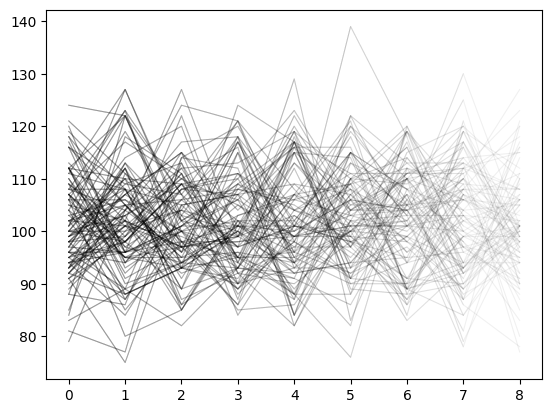

In [20]:
alpha_each = 0.06
lw_each = 0.8
n_samples = 100

for _ in range(n_samples):
    n_events, start_times, end_times = evolving_SBM_generate.EDEDE(activ_tau= activ_tau, inter_tau= inter_tau, t_start=0, t_end=100)

    snapshot_edges = []
    for interval in bins:
        snapshot_edges.append(count_interval_events(start_times, end_times, interval[0], interval[1]))
        plt.plot(snapshot_edges, alpha=alpha_each, linewidth=lw_each, color="k")

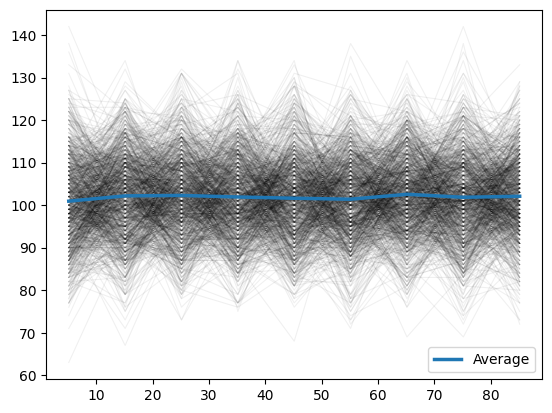

In [22]:
alpha_each = 0.06
lw_each = 0.8
n_samples = 1000

bin_centers = [(a + b) / 2 for a, b in bins]  # x-locations for plotting
all_snapshots = []

for _ in range(n_samples):
    n_events, start_times, end_times = evolving_SBM_generate.EDEDE(
        activ_tau=activ_tau, inter_tau=inter_tau, t_start=0, t_end=100
    )

    snapshot = [
        count_interval_events(start_times, end_times, interval[0], interval[1])
        for interval in bins
    ]
    all_snapshots.append(snapshot)
    plt.plot(bin_centers, snapshot, alpha=alpha_each, linewidth=lw_each, color="k")

mean_snapshot = np.mean(np.asarray(all_snapshots), axis=0)
plt.plot(bin_centers, mean_snapshot, color="tab:blue", linewidth=2.5, label="Average")
plt.legend()

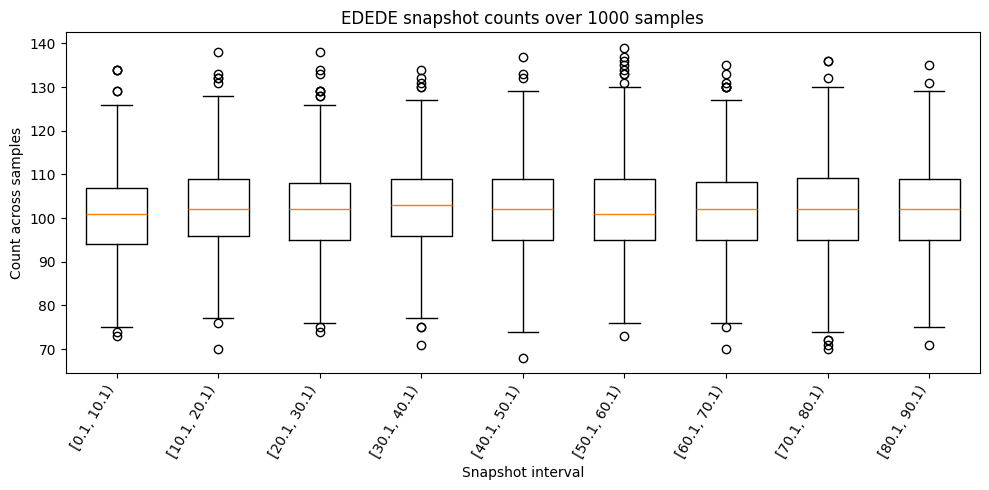

In [25]:
n_samples = 1000
all_snapshots = []

for _ in range(n_samples):
    n_events, start_times, end_times = evolving_SBM_generate.EDEDE(
        activ_tau=activ_tau, inter_tau=inter_tau, t_start=0, t_end=100
    )
    snapshot = [
        count_interval_events(start_times, end_times, interval[0], interval[1])
        for interval in bins
    ]
    all_snapshots.append(snapshot)

all_snapshots = np.asarray(all_snapshots)          # shape: (n_samples, n_bins)

fig, ax = plt.subplots(figsize=(10, 5))
ax.boxplot(all_snapshots, positions=np.arange(len(bins)), widths=0.6)

bin_labels = [f"[{a:.1f}, {b:.1f})" for a, b in bins]
ax.set_xticks(np.arange(len(bins)))
ax.set_xticklabels(bin_labels, rotation=60, ha="right")
ax.set_xlabel("Snapshot interval")
ax.set_ylabel("Count across samples")
ax.set_title(f"EDEDE snapshot counts over {n_samples} samples")
plt.tight_layout()
plt.show()


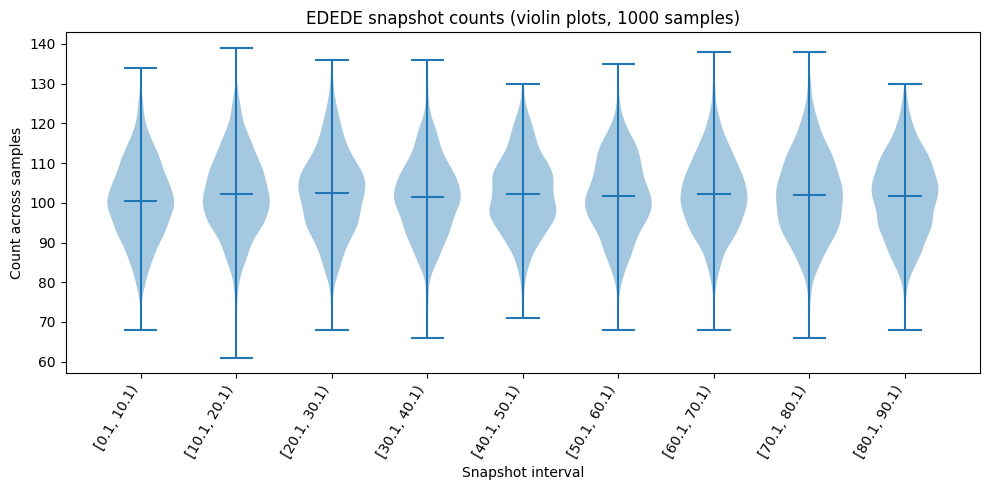

In [35]:
n_samples = 1000
all_snapshots = []
for _ in range(n_samples):
    n_events, start_times, end_times = evolving_SBM_generate.EDEDE(
        activ_tau=activ_tau, inter_tau=inter_tau, t_start=0, t_end=100
    )
    snapshot = [
        count_interval_events(start_times, end_times, interval[0], interval[1])
        for interval in bins
    ]
    all_snapshots.append(snapshot)

all_snapshots = np.asarray(all_snapshots)  # (n_samples, n_bins)

positions = np.arange(all_snapshots.shape[1])
bin_labels = [f"[{a:.1f}, {b:.1f})" for a, b in bins]

fig, ax = plt.subplots(figsize=(10, 5))
vp = ax.violinplot(all_snapshots, positions=positions, widths=0.7, showmeans=True)

for body in vp["bodies"]:
    body.set_facecolor("tab:blue")
    body.set_alpha(0.4)

ax.set_xticks(positions)
ax.set_xticklabels(bin_labels, rotation=60, ha="right")
ax.set_xlabel("Snapshot interval")
ax.set_ylabel("Count across samples")
ax.set_title(f"EDEDE snapshot counts (violin plots, {n_samples} samples)")
plt.tight_layout()
plt.show()
